In [9]:
# import necessary libraries
import random
import matplotlib.pyplot as plt

In [10]:
class Item:
    def __init__(self, value, weight):
        self.value = value
        self.weight = weight

class Knapsack:
    def __init__(self, capacity, items):
        self.capacity = capacity
        self.items = items

class Problem:
    def __init__(self, knapsack):
        self.knapsack = knapsack 
        self.num_params = 2 # number of parameters to optimize
        self.objectives = [self.totalValue, self.totalWeight] # list of objective functions to optimize
    
    # objective function 1: maximize the value
    def totalValue(self, selectedItems):
        selectedItems = [i for i, x in enumerate(selectedItems) if x == 1]
        return sum(self.knapsack.items[i].value for i in selectedItems)

    # objective function 2: minimize the weight
    def totalWeight(self, selectedItems):
        selectedItems = [i for i, x in enumerate(selectedItems) if x == 1]
        return sum(self.knapsack.items[i].weight for i in selectedItems)

class MOGA:
    def __init__(self, problem, population_size, generations):
        self.problem = problem
        self.population_size = population_size
        self.generations = generations       
    
    def initialize_population(self):
        population = []
        for i in range(self.population_size):
            solution = [random.randint(0, 1) for j in range(len(self.problem.knapsack.items))] # generate random solution
            valueFitness, weightFitness = self.fitness(solution) # evaluate the solution with fitness function
            population.append([solution,valueFitness,weightFitness]) # add the solution and fitnesses to population
        return population

    def fitness(self, solution):
        if self.problem.totalWeight(solution) > self.problem.knapsack.capacity: # if above capacity, penalize
            weightFitness = 999
            valueFitness = 0
        else:
            weightFitness = self.problem.totalWeight(solution)
            valueFitness = self.problem.totalValue(solution)
        return valueFitness, weightFitness

    def crossover(self, parent1, parent2):
        crossover_point = random.randint(1, len(parent1) - 1) # select random crossover point
        child1 = parent1[:crossover_point] + parent2[crossover_point:] # generate child1 
        child2 = parent2[:crossover_point] + parent1[crossover_point:] # generate child2
        return child1, child2

    def mutate(self, solution, mutation_rate):
        if random.random() < mutation_rate:
            random_index = random.randint(0, len(solution) - 1) # Select a random index
            solution[random_index] = 1 - solution[random_index] # Toggle the value at the selected index
        else:
            solution = solution
        return solution

    def fast_non_dominated_sort(self, population):
        # Initialize variables
        rank = {}
        S = {}
        n = {}
        fronts = [[]]

        # Determine domination relationships
        for i in range(len(population)):
            S[i] = []
            n[i] = 0
            for j in range(len(population)):
                if i == j:
                    continue
                if (population[i][1] > population[j][1] and population[i][2] <= population[j][2]) or (population[i][1] >= population[j][1] and population[i][2] < population[j][2]): # if j solution is dominated
                    if j not in S[i]:
                        S[i].append(j)
                elif (population[i][1] < population[j][1] and population[i][2] >= population[j][2]) or (population[i][1] <= population[j][1] and population[i][2] > population[j][2]): # if i solution is dominated
                    n[i] += 1

            # if i solution dominates
            if n[i] == 0: 
                rank[i] = 0
                fronts[0].append(i)

        # Determine subsequent fronts
        i = 0
        while len(fronts[i]) > 0:
            next_front = []
            for current_individual in fronts[i]:
                for j in S[current_individual]:
                    n[j] -= 1
                    if n[j] == 0:
                        rank[j] = i + 1
                        next_front.append(j)
            i += 1
            fronts.append(next_front)

        return fronts[:-1]

    # select two parents with the highest fitness (ties resolved randomly)
    # TODO: crowding distance
    def selection(self, fronts):
        if isinstance(fronts[0],list):
            if len(fronts[0]) > 1:
                selected = random.sample(fronts[0],2)
            else:
                if isinstance(fronts[1],list):
                    selected = [random.choice(fronts[0]),random.choice(fronts[1])]
                else:
                    selected = [random.choice(fronts[0]),fronts[1]]
        else:
            if isinstance(fronts[1],list):
                selected = [fronts[0],random.choice(fronts[1])]
            else:
                selected = [fronts[0],fronts[1]]

        return selected

    def run(self):
        population = self.initialize_population() # initialize population
        archive = []
        for generation in range(self.generations):

            # remove duplicates 
            unique_list = []
            for element in population:
                if element not in unique_list:
                    unique_list.append(element)
            if len(unique_list) > 1:
                population = unique_list

            new_population = []
            fronts = self.fast_non_dominated_sort(population) # calculate fronts
            archive = [population[index] for index in fronts[0]] # get archive
            selected = self.selection(fronts) # select parents
            c1,c2 = self.crossover(population[selected[0]][0], population[selected[1]][0]) # perform crossover
            childpop = []
            c1_mutated = self.mutate(c1, 0.1) # mutate child1
            c1_val, c1_weight = self.fitness(c1_mutated) # calculate fitness for child1
            childpop.append([c1_mutated,c1_val,c1_weight])
            c2_mutated = self.mutate(c2, 0.1) # mutate child2
            c2_val, c2_weight = self.fitness(c2_mutated) # calculate fitness for child2
            childpop.append([c2_mutated,c2_val,c2_weight])

            # compare child solutions with parento front solution
            new_population = archive + childpop
            new_fronts = self.fast_non_dominated_sort(new_population)
            if fronts[0] != new_fronts[0]: # if new parento front solution is found, add it to the new population, otherwise keep old parento solutions
                if isinstance(new_fronts[0],list):
                    if len(new_fronts[0]) > 1:
                        population = [new_population[index] for index in new_fronts[0]]
                    else:
                        if isinstance(new_fronts[1],list):
                            population = [new_population[index] for index in new_fronts[0]] + [new_population[random.choice(new_fronts[1])]]
                        else:
                            population = [new_population[index] for index in new_fronts[0]] + [new_population[new_fronts[1]]]
                else:
                    if isinstance(new_fronts[1],list):
                        population = [new_population[new_fronts[0]]] + [new_population[random.choice(new_fronts[1])]]
                    else:
                        population = [new_population[new_fronts[0]]] + [new_population[new_fronts[1]]]
            else:
                population = population
        return archive

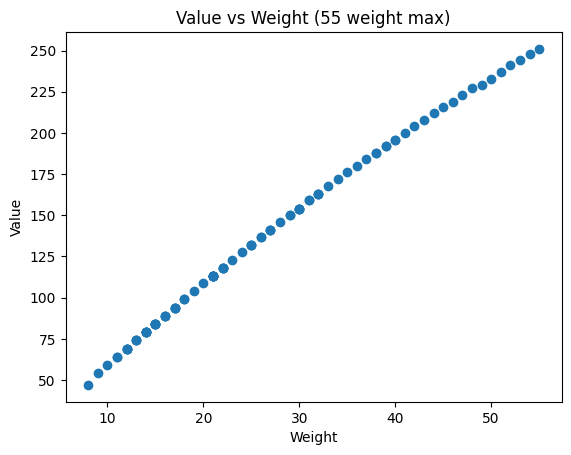

In [12]:
# define problem
moga = MOGA(Problem(Knapsack(
    capacity=55, 
    items = [
    Item(10, 2),
    Item(15, 3),
    Item(5, 1),
    Item(8, 4),
    Item(12, 2),
    Item(6, 1),
    Item(20, 5),
    Item(7, 3),
    Item(9, 2),
    Item(14, 4),
    Item(18, 6),
    Item(11, 3),
    Item(4, 1),
    Item(13, 2),
    Item(16, 4),
    Item(25, 7),
    Item(3, 1),
    Item(17, 3),
    Item(22, 5),
    Item(10, 2),
    Item(6, 1),
    Item(19, 4),
    Item(9, 2),
    Item(15, 3),
    Item(8, 2)])),
    population_size=10,
    generations=5000)

archive = moga.run()

# Extract the values and weights from the results
values = [x[1] for x in archive]
weights = [x[2] for x in archive]

# Create the scatter plot
plt.scatter(weights, values)
plt.xlabel('Weight')
plt.ylabel('Value')
plt.title('Value vs Weight (55 weight max)')

# Show the plot
plt.show()